In [25]:
from collections import defaultdict
import matplotlib.pyplot as plt
import jax.random as random
import jax.numpy as jnp
import jax
from enum import Enum
import matplotlib.tri as trimod
import sympy as sp
import numpy as np
import scipy.sparse as sps


class GridPattern(Enum):
    HEX = 1
    RECT = -1


def edge(a, b):
    return (min(a, b), max(a, b))


def redge(a, b):
    return (max(a, b), min(a, b))


class PlaneMesh:
    def __init__(
        self, n, perturb: float = 0.4, gridpattern: GridPattern = GridPattern.HEX
    ):
        if gridpattern == GridPattern.RECT:
            #### "grid"
            self.vertices1D = jnp.linspace(-1, 1, n)
            vertices = jnp.meshgrid(self.vertices1D, self.vertices1D)
            self.vertices = jnp.stack(vertices, axis=-1)
            self.vertices = self.vertices.reshape((n * n, 2))

            key = random.PRNGKey(0)
            width = 1.0 / (n - 1)
            perturbmask = jnp.ones_like(self.vertices) * perturb
            perturbmask = perturbmask.reshape((n, n, 2))
            perturbmask = perturbmask.at[:, 0].set([0, 0])
            perturbmask = perturbmask.at[0, :].set([0, 0])
            perturbmask = perturbmask.at[n - 1, :].set([0, 0])
            perturbmask = perturbmask.at[:, n - 1].set([0, 0])
            perturbmask = perturbmask.reshape((n * n, 2))
            self.vertices = (
                random.uniform(key, (n * n, 2), minval=-width, maxval=width)
                * perturbmask
                + self.vertices
            )
            self.border_mask = np.zeros((n, n), dtype=bool)
            self.border_mask[0, :] = True
            self.border_mask[-1, :] = True
            self.border_mask[:, 0] = True
            self.border_mask[:, -1] = True
            self.border_mask = self.border_mask.flatten()
            ####
        elif gridpattern == GridPattern.HEX:

            def get_hex_points(columns):
                long_row = np.linspace(-1, 1, columns)
                dist = 2 / (columns - 1) / 2
                small_row = np.linspace(-1 + dist, 1 - dist, columns - 1)
                print(dist)
                height = dist * 2 * np.sqrt(3) / 2
                print(height)
                vertices = []
                borders = []
                rows = int(np.ceil(2 / (height)))
                for row in range(rows):
                    odd = row % 2 == 0
                    height_coord = (-1 + (height * row)) * np.ones_like(
                        small_row if odd else long_row
                    )
                    to_add = np.vstack((small_row if odd else long_row, height_coord)).T
                    vertices.extend(to_add)
                    if row != 0 and row != rows - 1:
                        borders.extend([True] + [False] * (len(to_add) - 2) + [True])
                    else:
                        borders.extend([True] * len(to_add))
                return np.array(vertices), np.array(borders)

            self.vertices, self.border_mask = get_hex_points(n)
            dist = 2 / (n - 1) / 2
            self.vertices += (
                np.random.uniform(
                    low=-dist * perturb,
                    high=dist * perturb,
                    size=(len(self.vertices), 2),
                )
                * ~self.border_mask[:, None]
            )

        self.triangulation = trimod.Triangulation(
            self.vertices[:, 0].flatten(), self.vertices[:, 1].flatten()
        )

        self.precompute_matrices_and_properties()

    def precompute_matrices_and_properties(self):
        self.edgemap = [
            set() for _ in range(len(self.vertices))
        ]  # list of neighbors for each vertex
        self.trimap = [
            set() for _ in range(len(self.vertices))
        ]  # list of triangles for each vertex
        self.edges = set()

        for i, tri in enumerate(self.triangulation.triangles):
            for a, b in [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]:
                self.edgemap[a].add(b)
                self.edgemap[b].add(a)
                self.trimap[a].add(i)
                self.edges.add((a, b) if a < b else (b, a))

        self.trimap = [list(m) for m in self.trimap]
        self.edges = np.array(list(self.edges))
        self.triangles = np.array(self.triangulation.triangles)
        self.areas = PlaneMesh._get_areas(np.array(self.triangles), self.vertices)
        self.lengths = np.linalg.norm(
            self.vertices[self.edges[:, 0]] - self.vertices[self.edges[:, 1]], axis=1
        )
        self.d0 = PlaneMesh._get_exterior_derivate_0_matrix(self.vertices, self.edges)
        self.star0 = PlaneMesh._get_exterior_hodge_0_matrix(
            self.trimap, self.vertices, self.areas
        )
        self.star1_circ = PlaneMesh._get_exterior_hodge_1_circumcentric_matrix(
            self.lengths, self.vertices, self.edges, self.triangles
        )
        self.star1_bary = PlaneMesh._get_exterior_hodge_1_barycentric_matrix(
            self.lengths, self.vertices, self.edges, self.triangles
        )
        self.star2 = PlaneMesh._get_exterior_hodge_2_matrix(self.areas)
        self.d1 = PlaneMesh._get_exterior_derivate_1_matrix(self.triangles, self.edges)

    def _get_exterior_derivate_0_matrix(vertices, edges):
        A = np.zeros((len(edges), len(vertices)), dtype=int)
        for i, (from_, to) in enumerate(edges):
            A[i, from_] = -1
            A[i, to] = 1
        return A

    def _get_exterior_derivate_1_matrix(triangles, edges):
        A = np.zeros((len(triangles), len(edges)), dtype=int)
        for it, tri in enumerate(triangles):
            for i, edge_ in enumerate(
                [edge(tri[0], tri[1]), edge(tri[1], tri[2]), edge(tri[2], tri[0])]
            ):
                index = np.where(edges == edge_)[0]
                A[it, index] = 1 if edge_[0] == tri[i] else -1
        return A

    def _get_exterior_hodge_0_matrix(trimap, vertices, areas):
        A = np.zeros((len(vertices), len(vertices)), dtype=float)
        for i in range(len(vertices)):
            adjacent_tris = trimap[i]
            # known as the barycentric dual area of the vertex i
            A[i, i] = (1.0 / 3.0) * jnp.sum(areas[adjacent_tris])
        return A

    def _get_exterior_hodge_1_circumcentric_matrix(lengths, vertices, edges, triangles):
        # for each edge, we want to find the opposing vertex of the triangle.
        opposing_vertices = [[] for _ in range(len(edges))]

        for i, tri in enumerate(triangles):
            for j in range(3):
                a, b, c = tri[j], tri[(j + 1) % 3], tri[(j + 2) % 3]
                index = np.where((edges == edge(a, b)).all(axis=1))[0][0]
                opposing_vertices[index].append(int(c))

        A = np.zeros((len(edges), len(edges)), dtype=float)
        for i in range(len(edges)):
            (a, b) = edges[i]

            weights = []
            for oppo in opposing_vertices[i]:
                c = vertices[oppo]
                ca = vertices[a] - c
                ca /= np.linalg.norm(ca)
                cb = vertices[b] - c
                cb /= np.linalg.norm(cb)
                angle = np.arccos(np.dot(ca, cb))
                weights.append(np.cos(angle) / np.sin(angle))

            A[i, i] = 0.5 * sum(weights)  # / lengths[i]
        return A

    def _get_exterior_hodge_1_barycentric_matrix(lengths, vertices, edges, triangles):
        # for each edge, we want to find the opposing vertex of the triangle.
        opposing_vertices = [[] for _ in range(len(edges))]

        for i, tri in enumerate(triangles):
            for j in range(3):
                a, b, c = tri[j], tri[(j + 1) % 3], tri[(j + 2) % 3]
                index = np.where((edges == edge(a, b)).all(axis=1))[0][0]
                opposing_vertices[index].append(int(c))

        A = np.zeros((len(edges), len(edges)), dtype=float)
        for i in range(len(edges)):
            (a, b) = edges[i]

            barycenters = []
            for oppo in opposing_vertices[i]:
                c = vertices[oppo]
                barycenter = (vertices[a] + vertices[b] + c) / 3
                barycenters.append(barycenter)
            if len(barycenters) == 2:
                A[i, i] = np.linalg.norm(barycenters[0] - barycenters[1]) / lengths[i]
            else:
                A[i, i] = 1
        return A

    def _get_exterior_hodge_2_matrix(areas):
        return np.diag(1.0 / areas)

    def _get_areas(tris, vertices):
        areas = np.zeros(len(tris))
        for i, tri in enumerate(tris):
            a, b, c = vertices[tri]
            # compute triangle area using determinant
            ab = b - a
            ac = c - a
            areas[i] = 0.5 * np.abs(ab[0] * ac[1] - ab[1] * ac[0])
        return areas

    def plot_write_vertices(self, ax: plt.Axes):
        ax.plot(self.vertices[:, 0], self.vertices[:, 1], "x", c="black", markersize=5)
        ax.set_aspect("equal")
        eps = 0.1
        ax.set_xlim(-1 - eps, 1 + eps)
        ax.set_ylim(-1 - eps, 1 + eps)
        # draw all vertex numbers
        for i in range(len(self.vertices)):
            ax.text(
                self.vertices[i, 0],
                self.vertices[i, 1],
                str(i),
                fontsize=8,
            )

    def plot_mesh(self, ax: plt.Axes):
        ax.triplot(self.triangulation, color="black", linewidth=0.5)
        ax.set_aspect("equal")

    def plot_edges_oriented(self, ax: plt.Axes):
        ax.set_aspect("equal")

        for edge in self.edges:
            (from_, to) = edge
            (x1, y1) = self.idx(from_)
            (x2, y2) = self.idx(to)
            ax.arrow(
                x=x1,
                y=y1,
                dx=(x2 - x1) * 0.5,
                dy=(y2 - y1) * 0.5,
                color="black",
                length_includes_head=False,
                head_width=0.03,
                head_length=0.04,
                linewidth=0.0,
            )
            ax.plot([x1, x2], [y1, y2], color="black", linewidth=0.6)

    def plot_faces_oriented(self, ax: plt.Axes):
        ax.set_aspect("equal")
        for i, tri in enumerate(self.triangulation.triangles):
            coords = jnp.array([self.idx(p) for p in tri])
            coords = jnp.hstack(
                [coords, jnp.zeros((3, 1))]
            )  # add z=0 because cross product is 3D
            barycenter = jnp.mean(coords[:, :2], axis=0)  # only take mean of x and y
            normal = jnp.cross(coords[1] - coords[0], coords[2] - coords[0])
            normal = normal / jnp.linalg.norm(normal)
            ax.arrow(
                x=barycenter[0],
                y=barycenter[1],
                dx=normal[2] * 0.1,
                dy=normal[2] * 0.1,
                color="black",
                length_includes_head=True,
                head_width=0.03,
                head_length=0.04,
            )
            ax.text(
                barycenter[0],
                barycenter[1],
                "+" if normal[2] > 0 else "-",
                fontsize=8,
                horizontalalignment="left",
                verticalalignment="top",
            )

    def overwrite_border(self, values: list[float], borderval: float) -> list[float]:
        for i, is_border in enumerate(self.border_mask):
            if is_border:
                values[i] = borderval
        return values

    def plot_write_vertex_values(self, ax: plt.Axes, vertex_values):
        assert len(vertex_values) == len(self.vertices), (
            len(vertex_values),
            len(self.vertices),
        )
        ax.set_aspect("equal")
        for i in range(len(vertex_values)):
            (x, y) = self.idx(i)
            ax.text(
                x,
                y,
                str(vertex_values[i]),
                fontsize=8,
            )
            ax.scatter(x, y, c="black", s=10)

    def plot_write_edge_values(self, ax: plt.Axes, edge_values):
        assert len(edge_values) == len(self.edges)
        ax.set_aspect("equal")
        for i in range(len(edge_values)):
            (from_, to) = self.edges[i]
            (x1, y1) = self.idx(from_)
            (x2, y2) = self.idx(to)
            x = (x1 + x2) / 2
            y = (y1 + y2) / 2

            offset = (y2 - y1, x1 - x2)

            ax.text(
                x + offset[0] * 0.05,
                y + offset[1] * 0.05,
                str(edge_values[i]),
                fontsize=8,
                horizontalalignment="left",
                verticalalignment="center",
            )

    def plot_write_face_values(self, ax: plt.Axes, triangle_values):
        assert len(triangle_values) == len(self.triangulation.triangles)
        ax.set_aspect("equal")
        for i in range(len(triangle_values)):
            points = self.triangulation.triangles[i]
            coords = jnp.array([self.idx(p) for p in points])
            barycenter = jnp.mean(coords, axis=0)
            ax.text(
                barycenter[0],
                barycenter[1],
                str(triangle_values[i]),
                fontsize=8,
                horizontalalignment="center",
                verticalalignment="center",
            )

    def plot_interpolate_values(self, ax: plt.Axes, values, minmax=(None, None)):
        ax.set_aspect("equal")
        ax.figure.colorbar(
            ax.tripcolor(
                self.triangulation,
                values,
                cmap=plt.get_cmap("viridis"),
                shading="gouraud",
                vmin=minmax[0],
                vmax=minmax[1],
            )
        )

    def idx(self, i):
        return self.vertices[i]

    def dump_to_JSON(self, filename, vertex_values):
        import json

        verts = np.hstack(
            [self.vertices, 0.5 * np.random.random((len(self.vertices), 1))]
        )

        verts = np.hstack(
            [
                self.vertices,
                (self.vertices[:, 0] ** 2 + self.vertices[:, 1] ** 2).reshape(-1, 1),
            ]
        )

        mesh_data = {
            "vertices": verts.round(3).tolist(),
            "faces": self.triangles.tolist(),
            "values": vertex_values.round(3).tolist(),
        }

        # Save to a JSON file
        with open(filename, "w") as file:
            json.dump(mesh_data, file)


def discreteTiledPlaneLaplacian(mesh: PlaneMesh, values, border_value=0):
    laplacian = [0] * len(mesh.vertices)
    side = int(np.sqrt(len(mesh.vertices)))
    for i in range(len(mesh.vertices)):
        nidx = jnp.array([i % side, i // side])
        npos = mesh.idx(i)

        if mesh.border_mask[i]:
            laplacian[i] = border_value
            continue
        else:
            for dir in [[[-1, 0], [1, 0]], [[0, -1], [0, 1]]]:
                # go through 2 neighbors.

                """ laplacian idea:
we have a function evaluated in points [x-n, x, x+m] with values [a, b, c]

we look for the unique polynomial of degree 2 that interpolates these points, so ix^2 + jx + k.
We then take the laplacian of this polynomial and evaluate it at x=0, giving 2i.

In closed form, we get that i = (a*m - b*(m+n) + c*m) / (n*m)*(n+m). 
This is derived at the bottom of the notebook using sympy.
"""

                dists = []  # [-n, m]
                evals = []  # [a, c]
                for x, y in nidx + jnp.array(dir):
                    idx = x + y * side
                    dist = (mesh.idx(idx) - npos) @ jnp.array(dir[1])
                    dists.append(dist)
                    evals.append(values[x + y * side])

                a, b, c = (evals[0], values[i], evals[1])  # [a, b, c]
                n, m = (-dists[0], dists[1])  # [n, m]

                laplacian_one_direction = (
                    2 * (a * m - b * (m + n) + c * n) / (m * n * (m + n))
                )
                laplacian[i] += laplacian_one_direction
                # break

    return jnp.array(laplacian)

0.25
0.4330127018922193


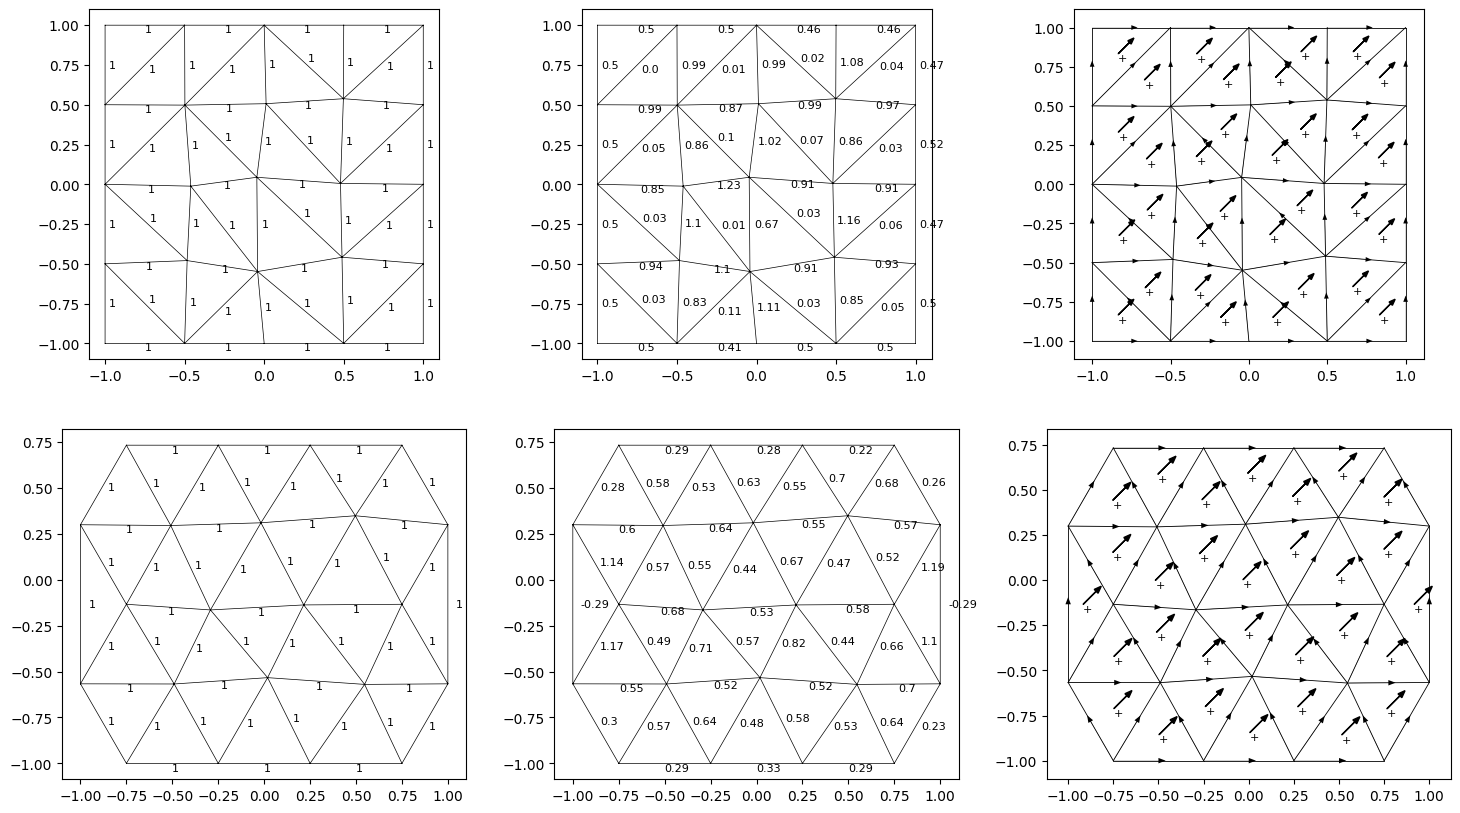

In [26]:
fig, axs = plt.subplots(2, 3, figsize=((5 + 1) * 3, (5) * 2), dpi=100)
row0, row1 = axs
(ax1, ax2, ax3) = row0
(ax4, ax5, ax6) = row1
mesh = PlaneMesh(5, perturb=0.2, gridpattern=GridPattern.RECT)

mesh.plot_mesh(ax1)
values = [1] * mesh.edges.__len__()
mesh.plot_write_edge_values(ax1, values)

mesh.plot_mesh(ax2)
values = [1] * mesh.edges.__len__()
values = (mesh.star1_circ @ values).round(2)
mesh.plot_write_edge_values(ax2, values)

mesh.plot_edges_oriented(ax3)
mesh.plot_faces_oriented(ax3)

mesh = PlaneMesh(5, perturb=0.2, gridpattern=GridPattern.HEX)

mesh.plot_mesh(ax4)
values = [1] * mesh.edges.__len__()
mesh.plot_write_edge_values(ax4, values)

mesh.plot_mesh(ax5)
values = [1] * mesh.edges.__len__()
values = (mesh.star1_circ @ values).round(2)
mesh.plot_write_edge_values(ax5, values)

mesh.plot_edges_oriented(ax6)
mesh.plot_faces_oriented(ax6)

In [27]:
from sympy import cos, sin

x, y = sp.symbols("x y")
f_symbolic = 0.1 * (0.3 * x**2 + 0.8 * y**2 + 2 * sin(2 * (3 * x + y**2)))
# f_symbolic = x**2 + y**2

f_laplacian_symbolic = sp.diff(f_symbolic, x, x) + sp.diff(f_symbolic, y, y)

f = jnp.vectorize(sp.lambdify((x, y), f_symbolic, "jax"))
f_laplacian = jnp.vectorize(sp.lambdify((x, y), f_laplacian_symbolic, "jax"))
from jax import jit

f = jit(f)
f_laplacian = jit(f_laplacian)

## Tri-mesh Barycentric-Laplacian

0.041666666666666664
0.07216878364870322
MSE: 0.009507948


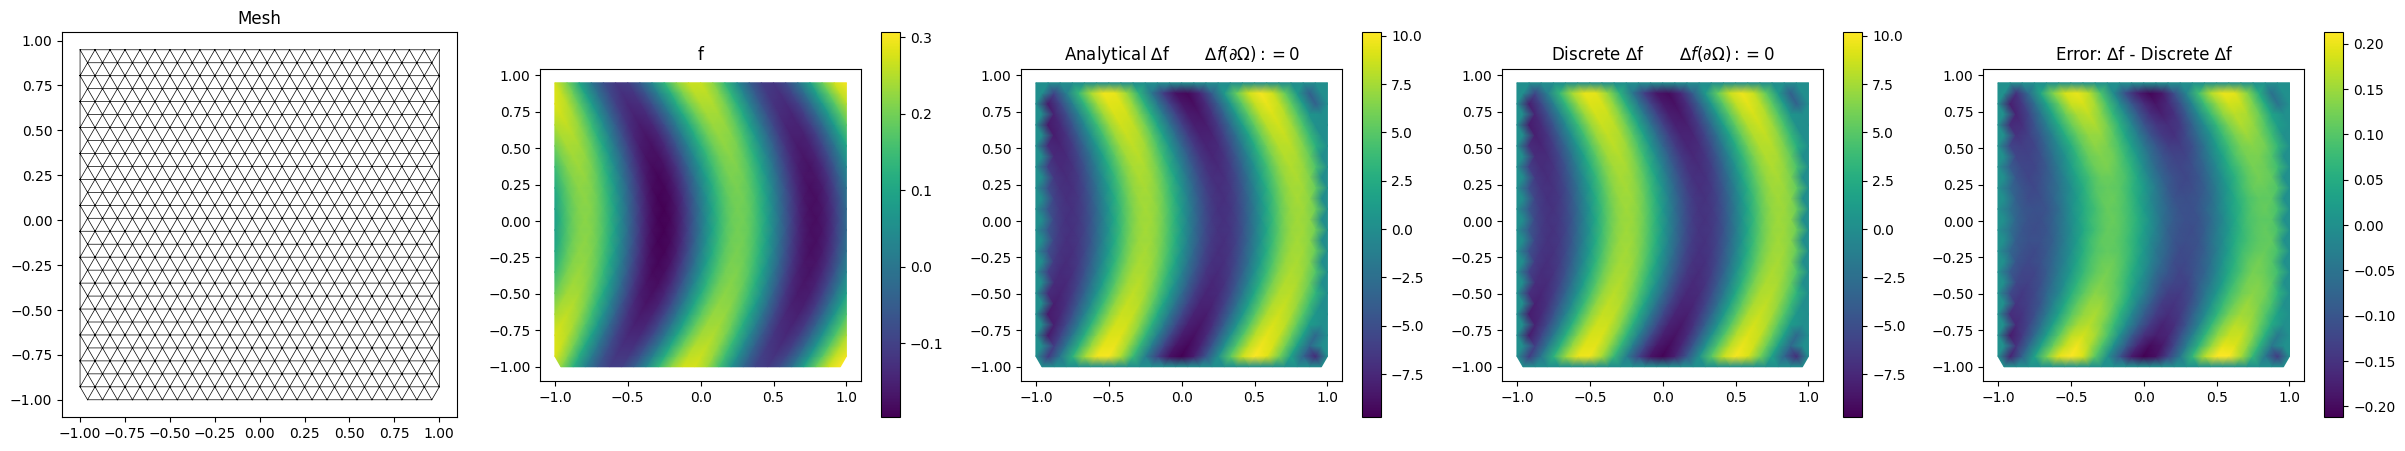

In [28]:
mesh = PlaneMesh(25, perturb=0.0, gridpattern=GridPattern.HEX)
fig, axs = plt.subplots(1, 5, figsize=((5 + 1) * 5, 5), dpi=100)
(ax1, ax2, ax3, ax4, ax5) = axs

ax1.set_title("Mesh")
mesh.plot_mesh(ax1)

f_samples = f(mesh.vertices[:, 0], mesh.vertices[:, 1])
mesh.plot_interpolate_values(ax2, f_samples.flatten())
ax2.set_title("f")

f_laplacian_samples = (
    f_laplacian(mesh.vertices[:, 0], mesh.vertices[:, 1]) * ~mesh.border_mask
)

lap_min = jnp.min(f_laplacian_samples)
lap_max = jnp.max(f_laplacian_samples)

laplace_matrix = np.linalg.inv(mesh.star0) @ mesh.d0.T @ mesh.star1_bary @ mesh.d0
discrete_f_laplacian = (laplace_matrix @ f_samples.flatten()).round(2)
mesh.border_mask = mesh.border_mask.flatten()
discrete_f_laplacian = -discrete_f_laplacian * ~mesh.border_mask

disc_lap_min = jnp.min(discrete_f_laplacian)
disc_lap_max = jnp.max(discrete_f_laplacian)

min_val = lap_min
max_val = lap_max

min_val = min(lap_min, disc_lap_min)
max_val = max(lap_max, disc_lap_max)


mesh.plot_interpolate_values(
    ax3, f_laplacian_samples.flatten(), minmax=(min_val, max_val)
)
ax3.set_title(r"Analytical ∆f       $∆f(\partial\Omega) := 0$")

mesh.plot_interpolate_values(
    ax4, discrete_f_laplacian.flatten(), minmax=(min_val, max_val)
)
ax4.set_title(r"Discrete ∆f       $∆f(\partial\Omega) := 0$")
ax5.set_title("Error: ∆f - Discrete ∆f")
print(
    "MSE:",
    np.mean((f_laplacian_samples.flatten() - discrete_f_laplacian.flatten()) ** 2),
)
mesh.plot_interpolate_values(
    ax5,
    f_laplacian_samples.flatten() - discrete_f_laplacian.flatten(),
    minmax=(None, None),
)

In [29]:
mesh.dump_to_JSON("hex.json", f_samples.flatten())

# Regular Rect-grid Laplacian

MSE: 0.009695023


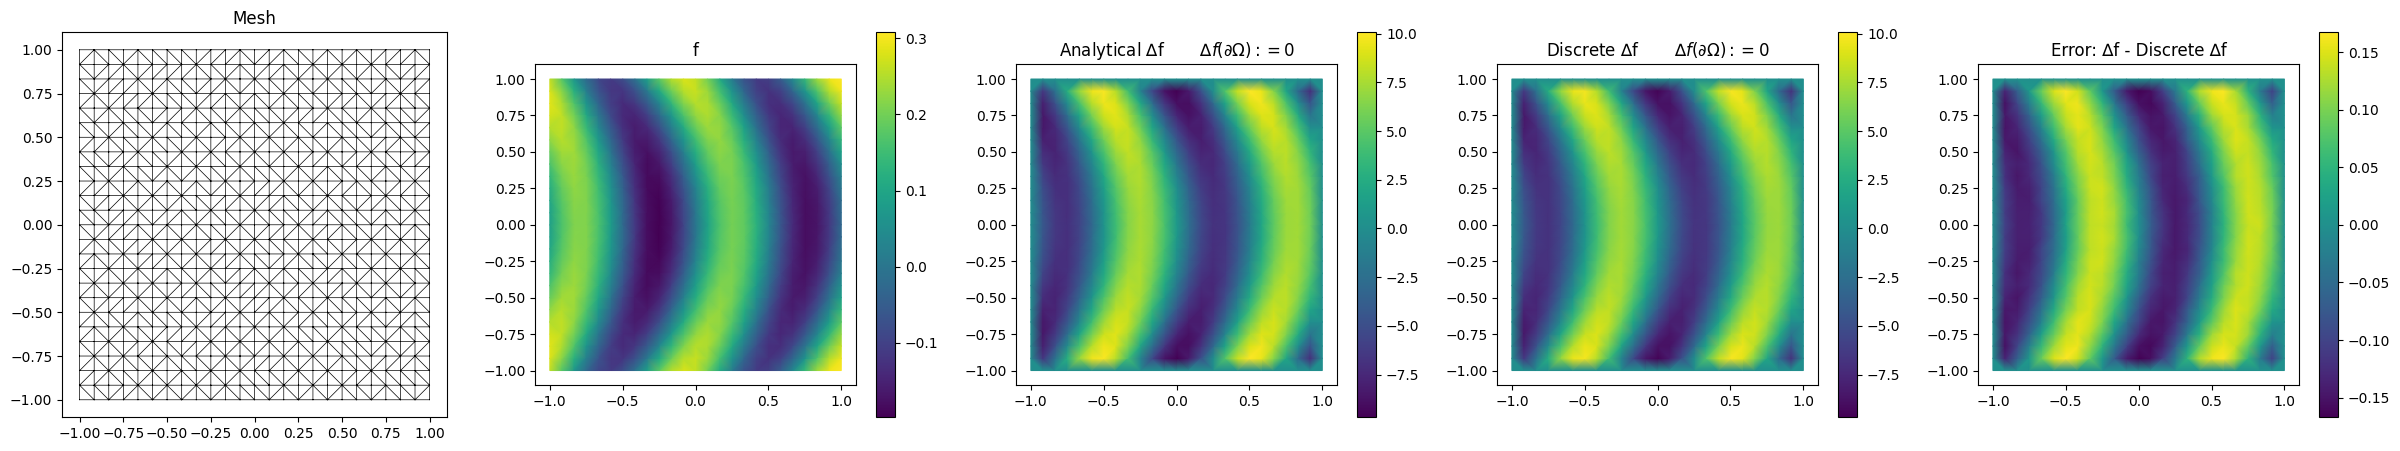

In [30]:
mesh = PlaneMesh(25, perturb=0.0, gridpattern=GridPattern.RECT)
fig, axs = plt.subplots(1, 5, figsize=((5 + 1) * 5, 5), dpi=100)
(ax1, ax2, ax3, ax4, ax5) = axs

ax1.set_title("Mesh")
mesh.plot_mesh(ax1)

f_samples = f(mesh.vertices[:, 0], mesh.vertices[:, 1])
mesh.plot_interpolate_values(ax2, f_samples.flatten())
ax2.set_title("f")

f_laplacian_samples = (
    f_laplacian(mesh.vertices[:, 0], mesh.vertices[:, 1]) * ~mesh.border_mask
)

lap_min = jnp.min(f_laplacian_samples)
lap_max = jnp.max(f_laplacian_samples)


discrete_f_laplacian = discreteTiledPlaneLaplacian(
    mesh, f_samples.flatten(), border_value=0
).round(2)
mesh.border_mask = mesh.border_mask.flatten()
discrete_f_laplacian = discrete_f_laplacian * ~mesh.border_mask

disc_lap_min = jnp.min(discrete_f_laplacian)
disc_lap_max = jnp.max(discrete_f_laplacian)

min_val = lap_min
max_val = lap_max

min_val = min(lap_min, disc_lap_min)
max_val = max(lap_max, disc_lap_max)


mesh.plot_interpolate_values(
    ax3, f_laplacian_samples.flatten(), minmax=(min_val, max_val)
)
ax3.set_title(r"Analytical ∆f       $∆f(\partial\Omega) := 0$")

mesh.plot_interpolate_values(
    ax4, discrete_f_laplacian.flatten(), minmax=(min_val, max_val)
)
ax4.set_title(r"Discrete ∆f       $∆f(\partial\Omega) := 0$")
ax5.set_title("Error: ∆f - Discrete ∆f")
print(
    "MSE:",
    np.mean((f_laplacian_samples.flatten() - discrete_f_laplacian.flatten()) ** 2),
)
mesh.plot_interpolate_values(
    ax5,
    f_laplacian_samples.flatten() - discrete_f_laplacian.flatten(),
    minmax=(None, None),
)

In [31]:
mesh.vertices.shape


mesh.dump_to_JSON("rect.json", f_samples.flatten())

### Deriving 2D Rectangle Grid laplacian

Matrix([
[                                             (a*m - b*(m + n) + c*n)/(m*n*(m + n))],
[          (-a*m*(m + 2*x) + b*(m + n)*(m - n + 2*x) + c*n*(n - 2*x))/(m*n*(m + n))],
[(a*m*x*(m + x) + b*(m + n)*(m*n - m*x + n*x - x**2) - c*n*x*(n - x))/(m*n*(m + n))]])

2*(a*m - b*(m + n) + c*n)/(m*n*(m + n))

(a*m - b*(m + n) + c*n)/(m*n*(m + n))


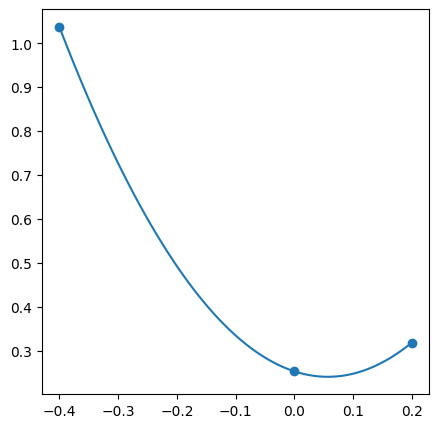

In [32]:
from sympy import Matrix
from IPython.display import display

ix, m, n = sp.symbols("x m n")

a, b, c = sp.symbols("a b c")

M = Matrix
(
    [
        [(ix - n) ** 2, ix - n, 1],
        [ix**2, ix, 1],
        [(ix + m) ** 2, ix + m, 1],
    ]
)

M = Matrix(
    3,
    3,
    [(ix - n) ** 2, ix - n, 1, ix**2, ix, 1, (ix + m) ** 2, ix + m, 1],
)

expression = M.inv() @ Matrix(3, 1, [a, b, c])
expression.simplify()
display(expression)
display(2 * expression[0].simplify())
print(str(expression[0]))


inv = sp.lambdify((ix, m, n), M.inv(), "numpy")
ix, n, m = (0, 0.4, 0.5)

a, b, c, b, m = [1.0375574, 0.5845615, 0.3188657, 0.25403935, 0.1998843]
vals = [a, b, c]

coefs = inv(ix, m, n) @ jnp.array(vals)


f = lambda x: coefs[0] * x**2 + coefs[1] * x + coefs[2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
domain = jnp.linspace(ix - n, ix + m, 100)
ax.plot(domain, f(domain), "-")
ax.scatter([ix - n, ix, ix + m], vals)

# investigating cotan laplacian behaviour for different mesh

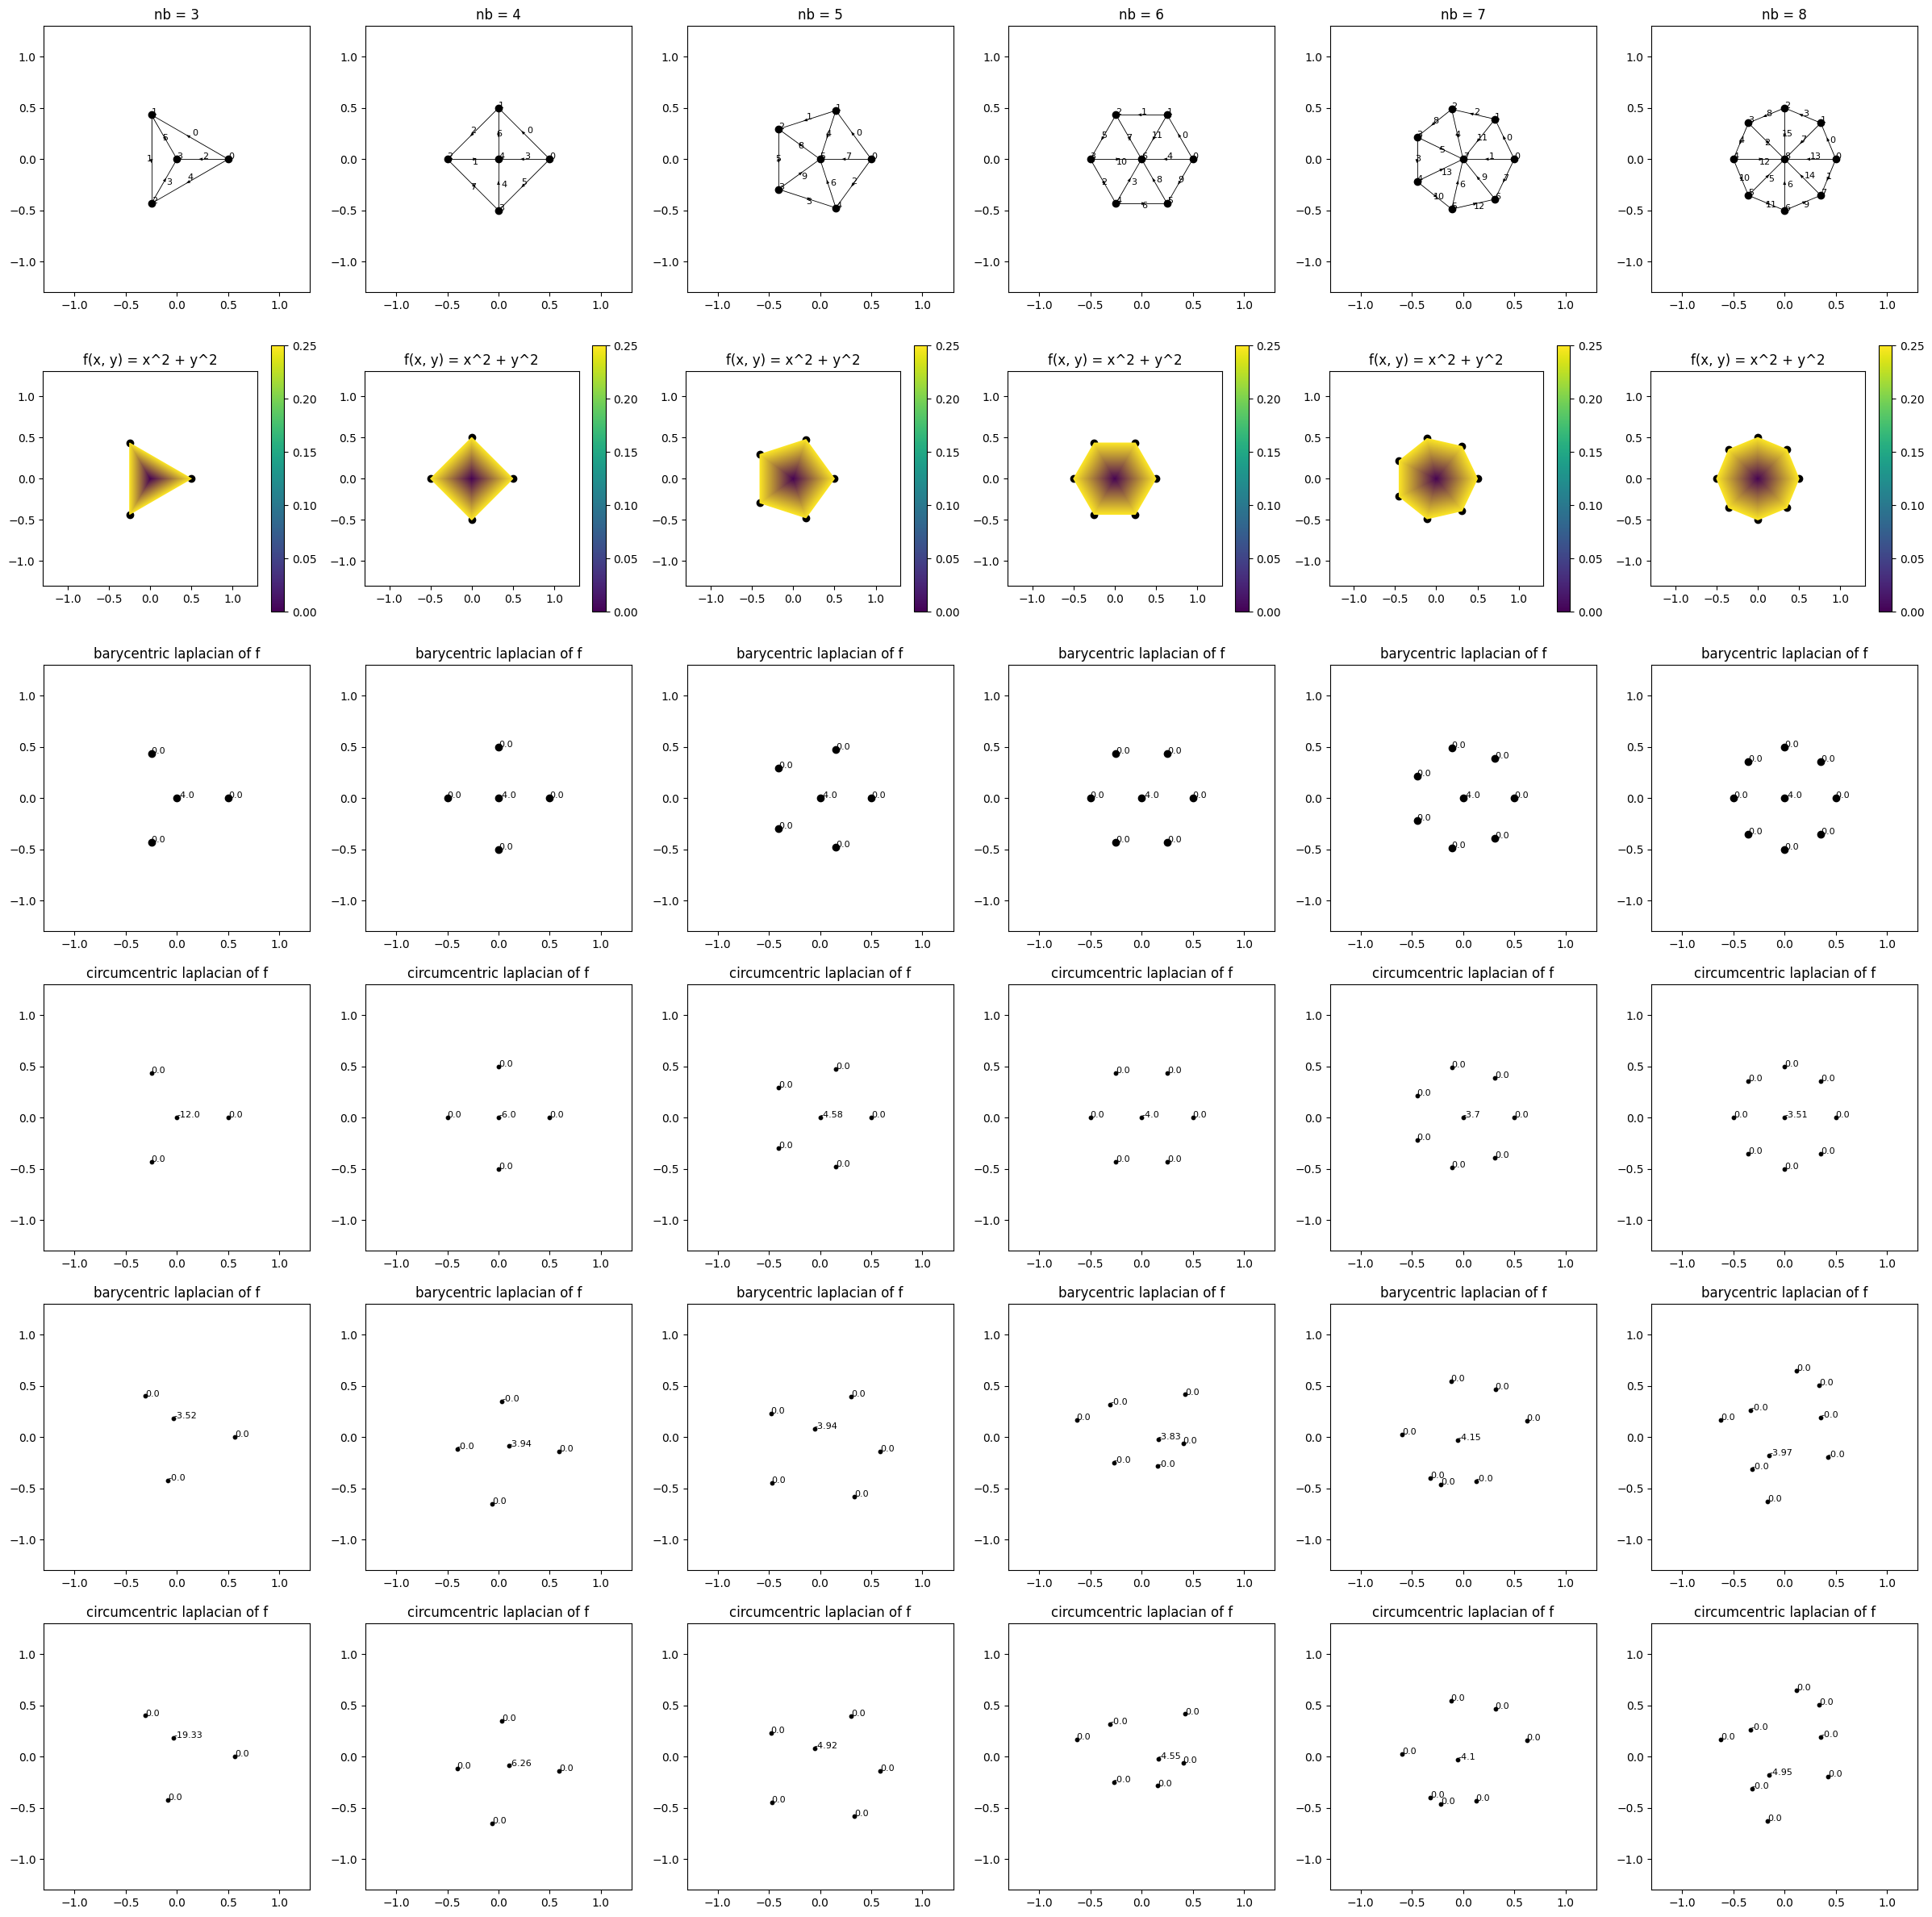

In [33]:
def gen_points(nbs: int):
    for i, theta in enumerate(np.linspace(0, 2 * np.pi, nbs, endpoint=False)):
        yield np.cos(theta), np.sin(theta)
    yield 0, 0


nbs = [3, 4, 5, 6, 7, 8]

fig, ax = plt.subplots(6, len(nbs), figsize=(5 * len(nbs), 5 * 6), dpi=100)

for exp, nb in enumerate(nbs):
    row0 = ax[0, exp]
    row1 = ax[1, exp]
    row2 = ax[2, exp]
    row3 = ax[3, exp]
    row4 = ax[4, exp]
    row5 = ax[5, exp]
    row0.set_title(f"nb = {nb}")
    for row in ax[:, exp]:
        row.set_aspect("equal")
        row.set_xlim(-1.3, 1.3)
        row.set_ylim(-1.3, 1.3)
    vertices = np.array(list(gen_points(nb))) * 0.5
    for i, (x, y) in enumerate(vertices):
        row0.scatter([x], [y], c="k")
        row1.scatter([x], [y], c="k")
        row2.scatter([x], [y], c="k")
    trimesh = trimod.Triangulation(vertices[:, 0], vertices[:, 1])

    mesh = PlaneMesh(
        n=2, perturb=0.0, gridpattern=GridPattern.RECT
    )  # doesnt matter what we assign, will overwrite
    mesh.vertices = vertices
    mesh.triangulation = trimesh
    mesh.precompute_matrices_and_properties()

    mesh.plot_edges_oriented(row0)
    mesh.plot_write_edge_values(row0, range(len(mesh.edges)))
    mesh.plot_write_vertex_values(row0, range(len(mesh.vertices)))

    values = np.array([x**2 + y**2 for x, y in vertices])
    row1.set_title("f(x, y) = x^2 + y^2")
    mesh.plot_interpolate_values(row1, (values).round(2))

    row2.set_title("barycentric laplacian of f")
    laplace_matrix = np.linalg.inv(mesh.star0) @ mesh.d0.T @ mesh.star1_bary @ mesh.d0
    discrete = (laplace_matrix @ values).round(2) * ~np.array(
        [True] * (len(vertices) - 1) + [False]
    )
    # mesh.plot_interpolate_values(row2, discrete, minmax=(None, None))
    mesh.plot_write_vertex_values(row2, discrete)

    row3.set_title("circumcentric laplacian of f")
    laplace_matrix = np.linalg.inv(mesh.star0) @ mesh.d0.T @ mesh.star1_circ @ mesh.d0
    discrete = (laplace_matrix @ values).round(2) * ~np.array(
        [True] * (len(vertices) - 1) + [False]
    )
    # mesh.plot_interpolate_values(row3, discrete, minmax=(None, None))
    mesh.plot_write_vertex_values(row3, discrete)

    vertices = vertices.copy() + np.random.uniform(
        low=-0.2, high=0.2, size=(len(vertices), 2)
    )
    trimesh = trimod.Triangulation(vertices[:, 0], vertices[:, 1])
    del mesh
    mesh = PlaneMesh(
        n=2, perturb=0.0, gridpattern=GridPattern.RECT
    )  # doesnt matter what we assign, will overwrite
    mesh.vertices = vertices
    mesh.triangulation = trimesh
    mesh.precompute_matrices_and_properties()

    values = np.array([x**2 + y**2 for x, y in vertices])

    row4.set_title("barycentric laplacian of f")
    laplace_matrix = np.linalg.inv(mesh.star0) @ mesh.d0.T @ mesh.star1_bary @ mesh.d0
    discrete = (laplace_matrix @ values).round(2) * ~np.array(
        [True] * (len(vertices) - 1) + [False]
    )
    # mesh.plot_interpolate_values(row4, discrete, minmax=(None, None))
    mesh.plot_write_vertex_values(row4, discrete)

    row5.set_title("circumcentric laplacian of f")
    laplace_matrix = np.linalg.inv(mesh.star0) @ mesh.d0.T @ mesh.star1_circ @ mesh.d0
    discrete = (laplace_matrix @ values).round(2) * ~np.array(
        [True] * (len(vertices) - 1) + [False]
    )
    # mesh.plot_interpolate_values(row5, discrete, minmax=(None, None))
    mesh.plot_write_vertex_values(row5, discrete)

In [34]:
0.58 * 6

3.4799999999999995

In [35]:
3.46 / 0.86

4.023255813953488

In [36]:
(1 / 3 * 8) / 0.67

3.980099502487562

In [37]:
np.pi * 1

3.141592653589793

In [38]:
fig, ax

nb = 6

vertices = np.array(list(gen_points(nb)))
for i, (x, y) in enumerate(vertices):
    row0.scatter([x], [y], c="k")
    row1.scatter([x], [y], c="k")
    row2.scatter([x], [y], c="k")
trimesh = trimod.Triangulation(vertices[:, 0], vertices[:, 1])
# row1.triplot(trimesh, color="black", linewidth=0.5)
mesh = PlaneMesh(
    n=2, perturb=0.0, gridpattern=GridPattern.RECT
)  # doesnt matter what we assign, will overwrite
mesh.vertices = vertices
mesh.triangulation = trimesh
mesh.precompute_matrices_and_properties()

mesh.plot_edges_oriented(row0)

values = np.zeros(len(vertices))
values[-1] = 1
row1.set_title("f(x, y) = x^2 + y^2")
mesh.plot_interpolate_values(row1, (values).round(2))

row2.set_title("laplacian of f")
laplace_matrix = np.linalg.inv(mesh.star0) @ mesh.d0.T @ mesh.star1_circ @ mesh.d0
discrete = (laplace_matrix @ values).round(2) * ~np.array(
    [True] * (len(vertices) - 1) + [False]
)
mesh.plot_interpolate_values(row2, discrete, minmax=(None, 6))
mesh.plot_write_vertex_values(row2, discrete)